## Customer Churn Prediction Model

Using the [Telco customer churn data](https://www.kaggle.com/code/mechatronixs/telco-churn-prediction-feature-engineering-eda/data) from kaggle, train_encoded_encoded_encoded_encoded_encoded a machine learning model to predict customer churn.

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import tree
from sklearn.metrics import accuracy_score
import xgboost as xgb


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from math import sqrt

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.tree import DecisionTreeRegressor

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)

In [33]:
# get training data
train = pd.read_csv("./data/training_data.csv")
# drop customer ID: not a feature for training 
train.drop("customerID", axis=1, inplace=True)

# getting validation data
val = pd.read_csv("./data/validation_data.csv")

In [34]:
print(f'colum number: {len(train.columns)}')
train.head()

colum number: 20


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,No,No,5,Yes,No,DSL,No,No,Yes,Yes,Yes,Yes,Month-to-month,No,Bank transfer (automatic),75.15,392.65,No
1,Male,0,Yes,No,66,Yes,Yes,DSL,No,No,No,Yes,No,Yes,Month-to-month,No,Electronic check,63.85,4264.6,No
2,Male,0,Yes,Yes,42,Yes,No,DSL,No,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,73.15,3088.25,No
3,Male,0,No,No,19,Yes,Yes,DSL,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,69.60,1394.55,No
4,Male,0,No,No,59,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),20.20,1192.3,No


In [35]:
print("Nulls:", train.isnull().any().any())
print("Nulls:", train.isnull().any())
print("NaNs:", train.isna().any().any())
print("NaNs:", train.isna().any())

print(train.TotalCharges.describe())

Nulls: False
Nulls: gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool
NaNs: False
NaNs: gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod 

In [36]:
# Deal with the spaces in TotalCharges and convert to float 
spaces = train[train['TotalCharges'] == " "]
train['TotalCharges'].loc[train['TotalCharges'] == " "] = '0.0'
#train['TotalCharges'] = train['TotalCharges'].astype(float)
train['TotalCharges'] = pd.to_numeric(train['TotalCharges'], errors='coerce')


/tmp/ipykernel_9794/4051407628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['TotalCharges'].loc[train['TotalCharges'] == " "] = '0.0'


In [37]:
column_names = list(train.columns)
print(column_names)
category_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 
                    'PaperlessBilling', 'PaymentMethod', 'Churn']
ordered_columns = ['Contract']
numeric_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
train.describe()

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,0.164710,32.375426,64.893449,2286.092361
std,0.370954,24.595876,30.142527,2277.456602
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,8.000000,35.562500,383.800000
50%,0.000000,29.000000,70.350000,1395.400000
75%,0.000000,56.000000,89.987500,3819.537500
max,1.000000,72.000000,118.750000,8684.800000


In [38]:
for n in category_columns:
    print(f'{n}', '\n',train.loc[:, n].value_counts(), '\n')

gender 
 Male      2670
Female    2612
Name: gender, dtype: int64 

Partner 
 No     2725
Yes    2557
Name: Partner, dtype: int64 

Dependents 
 No     3717
Yes    1565
Name: Dependents, dtype: int64 

PhoneService 
 Yes    4770
No      512
Name: PhoneService, dtype: int64 

MultipleLines 
 No                  2538
Yes                 2232
No phone service     512
Name: MultipleLines, dtype: int64 

InternetService 
 Fiber optic    2337
DSL            1806
No             1139
Name: InternetService, dtype: int64 

OnlineSecurity 
 No                     2613
Yes                    1530
No internet service    1139
Name: OnlineSecurity, dtype: int64 

OnlineBackup 
 No                     2314
Yes                    1829
No internet service    1139
Name: OnlineBackup, dtype: int64 

DeviceProtection 
 No                     2325
Yes                    1818
No internet service    1139
Name: DeviceProtection, dtype: int64 

TechSupport 
 No                     2612
Yes                    15

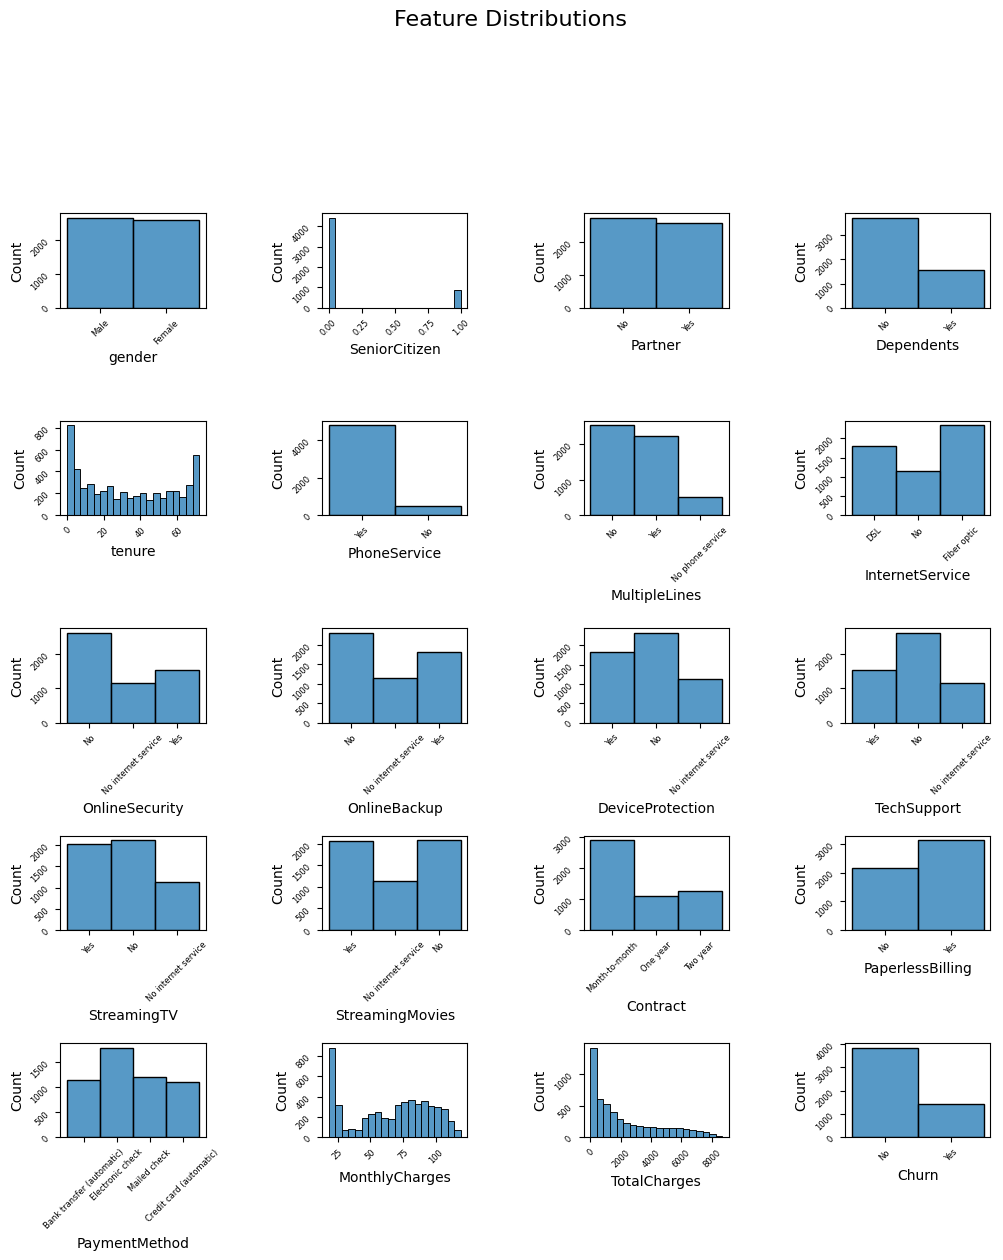

In [39]:
#rows = len(column_names)//2
fontsize = 6
fig, axs = plt.subplots(5, 4, figsize=(12, 12))
for i, column in enumerate(column_names): 
    row = i // 4
    col = i % 4
    sns.histplot(train[column], bins=20, ax=axs[row, col])
    #axs[row, col].set_title(column.capitalize())
    axs[row, col].tick_params(axis='both', which='major', labelsize=fontsize, labelrotation=45)

# Add a title for the whole figure
fig.suptitle('Feature Distributions', fontsize=16, y=1.05)

# Add some padding between the subplots
plt.subplots_adjust(hspace=1.2, wspace=0.8)

# display the plot
plt.show()

In [40]:
# create an object of the OneHotEncoder
ce_one = ce.OneHotEncoder(cols=category_columns) 

train_encoded = ce_one.fit_transform(train)
train_encoded.head()

,gender_1,gender_2,SeniorCitizen,Partner_1,Partner_2,Dependents_1,Dependents_2,tenure,PhoneService_1,PhoneService_2,MultipleLines_1,MultipleLines_2,MultipleLines_3,InternetService_1,InternetService_2,InternetService_3,OnlineSecurity_1,OnlineSecurity_2,OnlineSecurity_3,OnlineBackup_1,OnlineBackup_2,OnlineBackup_3,DeviceProtection_1,DeviceProtection_2,DeviceProtection_3,TechSupport_1,TechSupport_2,TechSupport_3,StreamingTV_1,StreamingTV_2,StreamingTV_3,StreamingMovies_1,StreamingMovies_2,StreamingMovies_3,Contract,PaperlessBilling_1,PaperlessBilling_2,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,MonthlyCharges,TotalCharges,Churn_1,Churn_2
0,1,0,0,1,0,1,0,5,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,Month-to-month,1,0,1,0,0,0,75.15,392.65,1,0
1,1,0,0,0,1,1,0,66,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,Month-to-month,1,0,0,1,0,0,63.85,4264.60,1,0
2,1,0,0,0,1,0,1,42,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,One year,1,0,0,1,0,0,73.15,3088.25,1,0
3,1,0,0,1,0,1,0,19,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,Month-to-month,1,0,0,0,1,0,69.60,1394.55,1,0
4,1,0,0,1,0,1,0,59,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,Two year,0,1,1,0,0,0,20.20,1192.30,1,0


In [41]:
# create a OneHotEncoder object
ohe = OneHotEncoder(drop='if_binary')

# fit and transform the categorical columns
encoded_columns = ohe.fit_transform(train[category_columns]).toarray()

# create a new dataframe with the encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=ohe.get_feature_names_out(category_columns))

# combine the encoded columns with the original dataframe
final_df = pd.concat([train.drop(category_columns, axis=1), encoded_df], axis=1)

final_df.head()

,SeniorCitizen,tenure,Contract,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,5,Month-to-month,75.15,392.65,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,66,Month-to-month,63.85,4264.60,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,42,One year,73.15,3088.25,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,19,Month-to-month,69.60,1394.55,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,59,Two year,20.20,1192.30,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [42]:
# Create a label encoder object

le = LabelEncoder()
encoded_columns = final_df[ordered_columns].apply(le.fit_transform)
final_df[ordered_columns] = encoded_columns

final_df.head()

,SeniorCitizen,tenure,Contract,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,5,0,75.15,392.65,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,66,0,63.85,4264.60,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,42,1,73.15,3088.25,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,19,0,69.60,1394.55,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,59,2,20.20,1192.30,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Feature Correlations')

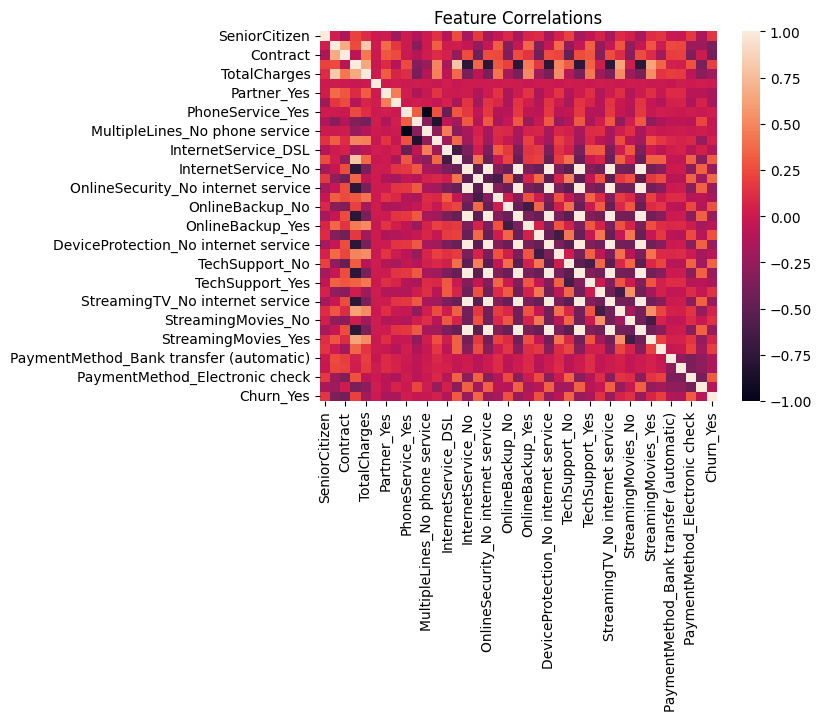

In [43]:
train_corrs = final_df.corr()
corr_heat = sns.heatmap(train_corrs)
plt.title('Feature Correlations')

In [45]:
# short = train_encoded.drop(['tenure','MonthlyCharges','TotalCharges'], axis=1)
# short_col = short.columns
# column_names_encoded = list(train_encoded.columns)

# #for n in column_names_encoded:
# for n in short_col:
#     print(n)
#     print(f'**** {n.upper()} ****')
#     print(f'Mean: ', round(train_encoded.loc[:, n].mean(),2))
#     print(f'Std Dev: ', round(train_encoded.loc[:, n].std(),2))
#     print(f'Min: ', round(train_encoded.loc[:, n].min(),2))
#     print(f'Median: ', round(train_encoded.loc[:, n].median(),2))
#     print(f'Max: ', round(train_encoded.loc[:, n].max(),2))

In [47]:
X = final_df.drop(['Churn_Yes'], axis=1)
y = final_df['Churn_Yes']

#train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [48]:
#initialize the decisiontreeclassifier
#They say that trees shouldn't be deeper than 5
dtc = tree.DecisionTreeClassifier(max_depth=5,random_state=42,criterion='gini')

#fit and return mean squared error
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)

mean_squared_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('DecisionTreeClassifier accuracy score: {}'.format(accuracy))

DecisionTreeClassifier accuracy score: 0.7975402081362346


In [52]:
xgb_model = xgb.XGBClassifier()

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = xgb_model.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.7729422894985809


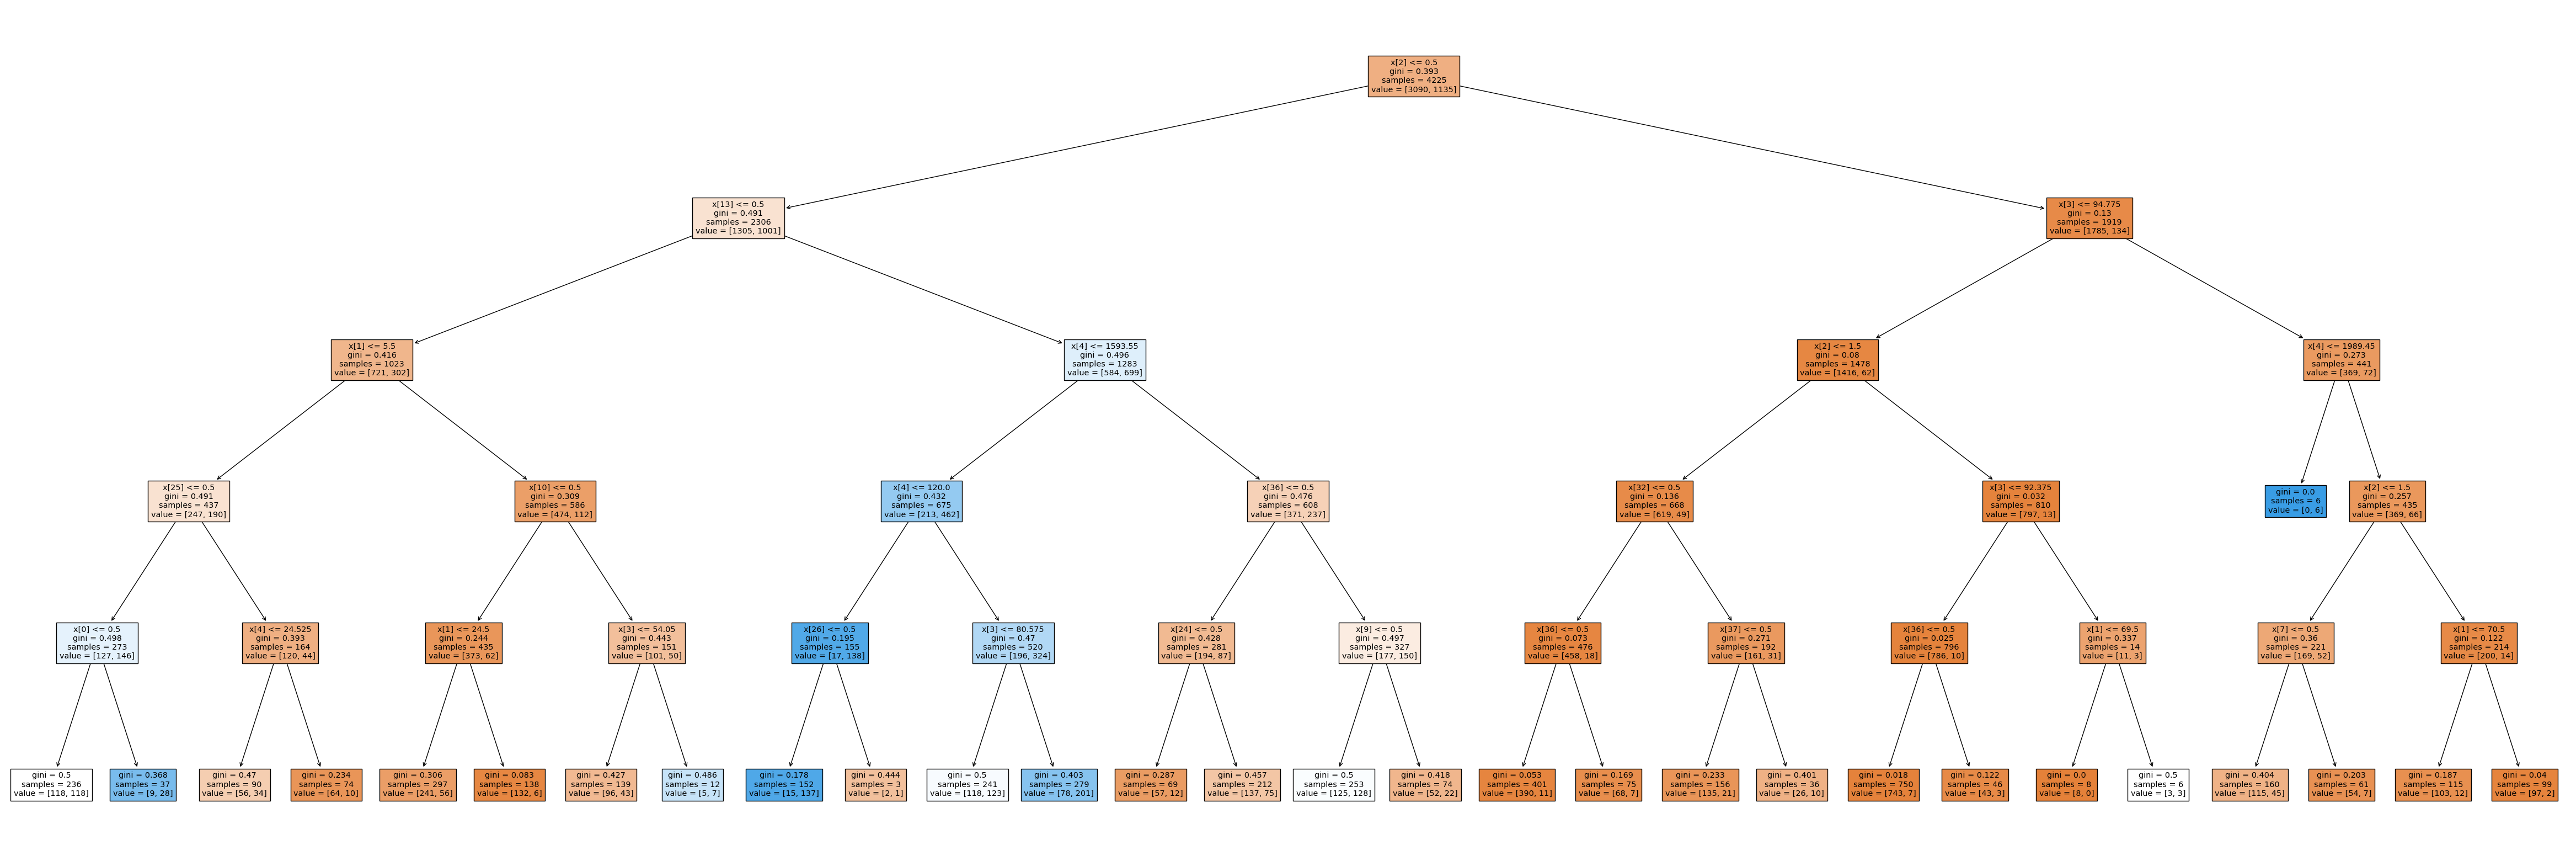

In [49]:
#show decision tree
plt.rcParams["figure.figsize"] = (60,20)
tree.plot_tree(dtc,filled = True);
